=====start image stitching=====


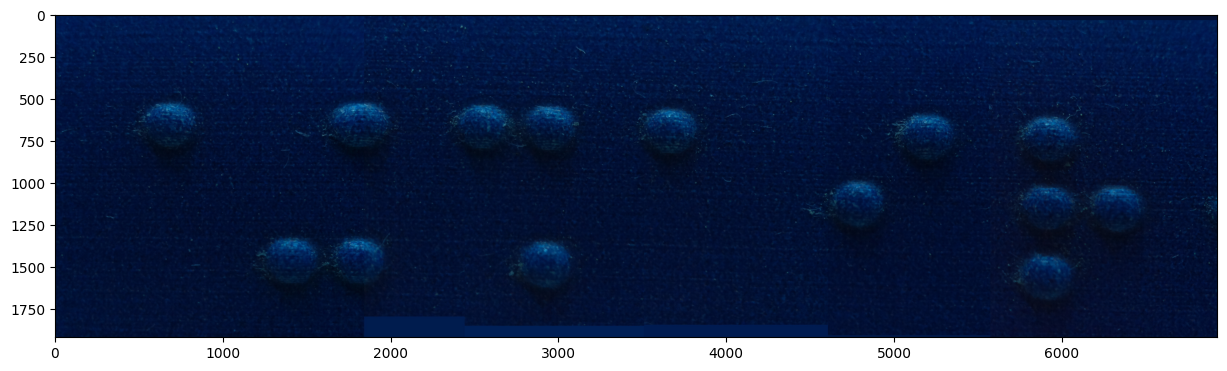

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import copy


plt.rcParams['figure.figsize'] = [15, 15]

# Read image and convert them to gray!!
def read_image(path):
    img = cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_gray, img_rgb


def SURF(img):
    surfDetector = cv2.xfeatures2d.SURF_create()  # limit 1000 points
    kp, des = surfDetector.detectAndCompute(img, None)
    return kp, des


def plot_sift(gray, rgb, kp):
    tmp = rgb.copy()
    img = cv2.drawKeypoints(gray, kp, tmp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img


def matcher(kp1, des1, kp2, des2, threshold):
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < threshold * n.distance:
            good.append([m])

    matches = []
    for pair in good:
        matches.append(list(kp1[pair[0].queryIdx].pt + kp2[pair[0].trainIdx].pt))

    matches = np.array(matches)
    return matches


# 호모그래피는 한 평면을 다른 평면에 투영시킬 때 둘 사이의 변환관계
# 행렬식( 호모그래피 )을 구하는 함수

def homography(pairs):
    rows = []
    for i in range(pairs.shape[0]):  # pairs(매칭점) 개수만큼
        p1 = np.append(pairs[i][0:2], 1)
        p2 = np.append(pairs[i][2:4], 1)
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1] * p1[0], -p2[1] * p1[1], -p2[1] * p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0] * p1[0], -p2[0] * p1[1], -p2[0] * p1[2]]
        rows.append(row1)
        rows.append(row2)
    rows = np.array(rows)
    U, s, V = np.linalg.svd(rows)  # svd는 특이값 분해
    H = V[-1].reshape(3, 3)  # H는 호모그래피
    H = H / H[2, 2]  # standardize to let w*H[2,2] = 1
    return H


# 매칭점에서 랜덤 포인트 추출
# 추출한 매칭점이 담긴 ndarray 반환

def random_point(matches, k=4):
    idx = random.sample(range(len(matches)), k)
    point = [matches[i] for i in idx]
    return np.array(point)


def get_error(points, H):
    num_points = len(points)
    all_p1 = np.concatenate((points[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = points[:, 2:4]
    estimate_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        temp = np.dot(H, all_p1[i])  # dot는 내적
        estimate_p2[i] = (temp / temp[2])[0:2]  # set index 2 to 1 and slice the index 0, 1
    # Compute error
    errors = np.linalg.norm(all_p2 - estimate_p2, axis=1) ** 2

    return errors


def ransac(matches, threshold, iters):
    num_best_inliers = 0  # 가장 많은 수의 인라이어

    for i in range(iters):
        points = random_point(matches)  # point는 리스트, 리스트 안의 point도 x, y, x, y 가 있는 리스트 형태
        H = homography(points)  # 매칭점을 호모그래피 함수에 전달

        #  avoid dividing by zero
        if np.linalg.matrix_rank(H) < 3:
            continue

        errors = get_error(matches, H)
        idx = np.where(errors < threshold)[0]
        inliers = matches[idx]

        # 더 좋은 선? 더 많은 인라이어가 있는 H 로 변경 및 인라이어들 기록
        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            num_best_inliers = num_inliers
            
            
def stitching(path):
    print("=====start image stitching=====")
    img_list = os.listdir(path)
    img_list = sorted(img_list, key = lambda x: int(x[5:-4]))
    img_list = [path + '/' + img for img in img_list]
    img_cnt = len(img_list)

    while len(img_list) != 1:
        left_gray, left_rgb = (0, 0)
        right_gray, right_rgb = (0, 0)
        
        img1, img2 = (0, 0)

        if len(img_list) == img_cnt:
            img1 = img_list[0]
            img2 = img_list[1]
            left_gray, left_rgb = read_image(img1)
            right_gray, right_rgb = read_image(img2)
        else:
            img1 = path + "/result.jpg"
            img2 = img_list[0]
            left_gray, left_rgb = read_image(img1)
            right_gray, right_rgb = read_image(img2)

        # Better result when using gray
        # key point, descriptor 추출
        kp_left, des_left = SURF(left_gray)
        kp_right, des_right = SURF(right_gray)

        # draw key point and descriptor
        # combine draw image
        kp_left_img = plot_sift(left_gray, left_rgb, kp_left)
        kp_right_img = plot_sift(right_gray, right_rgb, kp_right)
        total_kp = np.concatenate((kp_left_img, kp_right_img), axis=1)

        matches = matcher(kp_left, des_left, kp_right, des_right, 0.5)

        total_img = np.concatenate((left_rgb, right_rgb), axis=1)  # 합친 이미지

        ransac(matches, 0.5, 1000)

        left = left_rgb[:, 0:int(matches[0][0])]
        right = right_rgb[:, int(matches[0][2]):]

        diff = matches[0][1] - matches[0][3]

        # 오른쪽이 더 낮으면 윗부분을 자르고 아래에 붙인다
        if diff < 0:
            cut = right[:abs(int(diff)), :, ]
            cut[:, :, :] = cut[0:1, 0:1]
            right = right[abs(int(diff)):, :, :]
            right = np.vstack((right, cut))

        # 더 높으면 차이만큼 자르고, 위에 붙인다
        elif diff > 0:
            cut = right[-abs(int(diff)):, :, ]
            cut[:, :, :] = cut[0:1, 0:1]
            right = right[:-abs(int(diff)):, :, ]
            right = np.vstack((cut, right))

        combine = np.hstack((left, right))

        img_list.remove(img1)
        img_list.remove(img2)
        
        save = cv2.cvtColor(combine, cv2.COLOR_RGB2BGR)
        cv2.imwrite(path + "/result.jpg", save)
        img_list.append(path + "/result.jpg")    
    
    plt.imshow(combine)
    plt.show()
            
stitching('C:/Users/HwaJong/Desktop/stst')  